In [1]:
# pip install featurewiz --ignore-installed --no-deps

In [2]:
# pip install imbalanced_ensemble

In [3]:
# pip install lightgbm

# Modelo número 3: RandomForest

## Importando a base de dados - Cursos Enap

In [4]:
# -*- coding: utf-8 -*-

# Entrando com os pacotes necessários 

import pandas as pd # manipula os dados em DataFrame
import psycopg2 # conecta o banco sql ao python
import pandas.io.sql as sqlio # importa os dados do banco sql em formato Dataframe

# Colocando as informações de login no servidor

host = '10.224.9.157'
dbname= 'dw_consolidado' 
username = 'postgres' 
password = 'Enap@123' 

# Realizando a coneção com o banco de dados

conn = psycopg2.connect(host = host, dbname = dbname, user = username, password = password, port='5432')

In [5]:
%%time

# Puxando o banco de dados

sql = f"select cpf, curso, categoria_acao, conteudista, data_inicio_acao, vinculo_adm_pub, esfera, modalidade_acao, diretoria_acao from tb_fato_matricula inner join dim_aluno using (dim_aluno_id) inner join dim_origem_dado using (dim_origem_dado_id) inner join dim_acao using (dim_acao_id) inner join dim_situacao using (dim_situacao_id) left join tb_fato_indicadores using (id_fato_matricula) left join dim_avaliacao using (dim_avaliacao_id) where ((formato_acao = 'Curso') and (desc_situacao = 'Trancada' or desc_situacao = 'Cancelada' or desc_situacao = 'Desistente')) order by data_conclusao asc;"
df_aluno = sqlio.read_sql_query(sql, conn) # Pegando as tabelas de interesse 

df_aluno = df_aluno.drop_duplicates(subset=['cpf'], keep='last')

C:\Users\ferna\anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


Wall time: 8min 50s


## Importando a base de dados - Siape

In [6]:
# -*- coding: utf-8 -*-

# Entrando com os pacotes necessários 

import pandas as pd # manipula os dados em DataFrame
import psycopg2 # conecta o banco sql ao python
import pandas.io.sql as sqlio # importa os dados do banco sql em formato Dataframe

# Colocando as informações de login no servidor

host = '10.224.9.158'
dbname= 'postgres' 
username = 'fernando' 
password = 'Enap@22#' 

# Realizando a coneção com o banco de dados

conn = psycopg2.connect(host = host, dbname = dbname, user = username, password = password, port='5432')

In [7]:
%%time

# Puxando o banco de dados (SIAPE)

for mes in ['03', '06', '09', '12']:
    for ano in ['2021']:
        sql = f"select cpf_servidor, escolaridade, orgao, cargo, atividade_funcao from siape.amostra_{ano}_{mes} where cpf_servidor is not null;"
        globals()['df_%s_%s' % (mes,ano)] = sqlio.read_sql_query(sql, conn) # Pegando as tabelas de interesse 
        
for mes in ['03']:
    for ano in ['2022']:
        sql = f"select cpf_servidor, escolaridade, orgao, cargo, atividade_funcao from siape.amostra_{ano}_{mes} where cpf_servidor is not null;"
        globals()['df_%s_%s' % (mes,ano)] = sqlio.read_sql_query(sql, conn) # Pegando as tabelas de interesse 

# Realizando a concatenação das planilhas 

df_siape = pd.concat([
                  df_03_2021, df_06_2021, df_09_2021, df_12_2021,
                  df_03_2022])

df_siape = df_siape.drop_duplicates(subset=['cpf_servidor'], keep='last')

C:\Users\ferna\anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\ferna\anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\ferna\anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\ferna\anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqli

Wall time: 3min 1s


## Concatenando as duas bases

In [8]:
# Substituindo a coluna cpf_servidor por cpf

df_siape.rename(columns = {'cpf_servidor':'cpf'}, inplace = True)

# Realizando o merge entre siape e curso

df_aluno = pd.merge(df_aluno, df_siape, how = 'inner', on = 'cpf')

# Removendo cursos que tiveram menos de 10 cadastros

v = df_aluno[['curso']]
df_aluno = df_aluno[v.replace(v.stack().value_counts()).gt(5).all(1)]
df_aluno = df_aluno.reset_index()

del df_aluno['index']

# Pegando a entrada mais recente de cpf na base de dados

df_aluno['data_inicio_acao'] = pd.to_datetime(df_aluno['data_inicio_acao'])
df_aluno = df_aluno.sort_values(by='data_inicio_acao')

df_aluno = df_aluno.reset_index()
del df_aluno['index']

In [9]:
df_aluno = df_aluno.drop_duplicates(subset=['cpf'], keep='last')

df_aluno = df_aluno.reset_index()
del df_aluno['index']

## Conferindo a frequência de nulos

In [10]:
df_aluno.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167497 entries, 0 to 167496
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   cpf               167497 non-null  object        
 1   curso             167497 non-null  object        
 2   categoria_acao    157468 non-null  object        
 3   conteudista       167497 non-null  object        
 4   data_inicio_acao  167497 non-null  datetime64[ns]
 5   vinculo_adm_pub   167497 non-null  object        
 6   esfera            156183 non-null  object        
 7   modalidade_acao   167497 non-null  object        
 8   diretoria_acao    167497 non-null  object        
 9   escolaridade      167497 non-null  object        
 10  orgao             167497 non-null  object        
 11  cargo             167497 non-null  object        
 12  atividade_funcao  167497 non-null  object        
dtypes: datetime64[ns](1), object(12)
memory usage: 16.6+ MB


## Utilizando um Feature Extraction  automático

Imported version = 0.1.91.
from featurewiz import FeatureWiz
wiz = FeatureWiz(verbose=1)
X_train_selected = wiz.fit_transform(X_train, y_train)
X_test_selected = wiz.transform(X_test)
wiz.features  ### provides a list of selected features ###
                                
############################################################################################
############       F A S T   F E A T U R E  E N G G    A N D    S E L E C T I O N ! ########
# Be judicious with featurewiz. Don't use it to create too many un-interpretable features! #
############################################################################################
Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
**INFO: featurewiz can now read feather formatted files. Loading train data...
    Shape of your Data Set loaded: (167497, 11)
    Loaded train data. Shape = (167497, 11)
No test data filename given...
Classifying fe

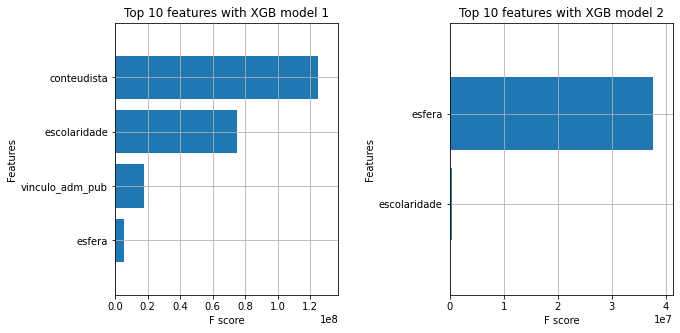

            Total time taken for XGBoost feature selection = 33 seconds
#######################################################################################
#####          F E A T U R E   S E L E C T I O N   C O M P L E T E D            #######
#######################################################################################
Selected 4 important features:
['conteudista', 'escolaridade', 'vinculo_adm_pub', 'esfera']

    Time taken for feature selection = 66 seconds
Returning 2 dataframes: dataname and test_data with 4 important features.


In [11]:
from featurewiz import featurewiz

# automatic feature selection by using featurewiz package
target = 'curso'
features_extraction = df_aluno[['curso','categoria_acao','conteudista','vinculo_adm_pub','esfera','modalidade_acao','diretoria_acao','escolaridade','orgao','cargo','atividade_funcao']]
 
features, train = featurewiz(features_extraction, target, corr_limit=0.7, verbose=2, sep=",", header=0,test_data="", feature_engg="", category_encoders="")

## Aplicando pesos as datas 

In [12]:
import datetime

valor = []
for i in range(0,len(df_aluno)):
    if df_aluno['data_inicio_acao'][i] < datetime.date(2020,1,1):
        valor.append(0)
    else:
        valor.append(1000)
        
df_aluno['Peso'] = valor

## Separando as variáveis

In [13]:
# Entrando com os pacotes necessários

import numpy as np
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor

# Separando as variáveis de interesse no estudo 

X = df_aluno[['escolaridade', 'vinculo_adm_pub','cargo','atividade_funcao','Peso']].values
X = X.astype(str)

y = df_aluno['curso']

# Shape do dataset

print(f'Shape: {X.shape}, {y.shape}')

Shape: (167497, 5), (167497,)


## Aplicando um modelo de Downsampling

In [14]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42, replacement=True)
x_rus, y_rus = rus.fit_resample(X, y)

## Separando em treino e teste

In [15]:
from sklearn.model_selection import train_test_split
 
X_train, X_test, y_train, y_test = train_test_split(
    x_rus, y_rus,
    test_size=0.3,
    stratify=y_rus
)
 
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2020, 5) (2020,)
(866, 5) (866,)


## Aplicando o CountEncoder

### Base de treino

In [16]:
import category_encoders
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# Separando a base em duas partes
df_encoding = pd.DataFrame(X_train, columns=['escolaridade', 'vinculo_adm_pub','cargo','atividade_funcao','Peso']) 

# CountEncoder
df_encoding_cat_treino = df_encoding[['escolaridade', 'vinculo_adm_pub', 'cargo','atividade_funcao']]
x_cat = category_encoders.CountEncoder().fit_transform(df_encoding_cat_treino.to_numpy())

# Retornando para numpy array
df_encoding_result = pd.concat([x_cat,df_encoding[['Peso']]], axis=1)
df_encoding_result.rename(columns = {0:'escolaridade', 1:'vinculo_adm_pub' , 2:'cargo', 3:'atividade_funcao'}, inplace = True)
X_enc_treino = df_encoding_result.to_numpy()

# Realizando uma padronização na escala das variáveis
scaler = StandardScaler()
x_cat_matriz = scaler.fit_transform(X_enc_treino)
X_enc = pd.DataFrame(x_cat_matriz, columns=['escolaridade', 'vinculo_adm_pub', 'cargo','atividade_funcao','Peso']) 

print(X_enc.shape)

# Codificando atributo alvo

label_enc = LabelEncoder()
y_enc = label_enc.fit_transform(y_train)
y_enc

(2020, 5)


array([ 83, 420, 353, ..., 367, 108, 140])

### Base de teste

In [17]:
import category_encoders
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Separando a base em duas partes
df_encoding_valid = pd.DataFrame(X_test, columns=['escolaridade',  'vinculo_adm_pub','cargo','atividade_funcao','Peso']) 

# CountEncoder
df_encoding_cat_treino_valid = df_encoding_valid[['escolaridade',  'vinculo_adm_pub', 'cargo','atividade_funcao']]

modelo_count = category_encoders.CountEncoder()
modelo_count.fit(df_encoding_cat_treino.to_numpy())

X_enc_teste = modelo_count.transform(df_encoding_cat_treino_valid.to_numpy())

# Retornando para numpy array
df_encoding_result = pd.concat([X_enc_teste,df_encoding_valid[['Peso']]], axis=1)
df_encoding_result.rename(columns = {0:'escolaridade', 1:'vinculo_adm_pub' , 2:'cargo', 3:'atividade_funcao'}, inplace = True)
X_enc_teste = df_encoding_result.to_numpy()

# Realizando uma padronização na escala das variáveis

scaler = StandardScaler()
scaler.fit(X_enc_treino)
x_cat_teste_matriz = scaler.transform(X_enc_teste)

X_enc_teste = pd.DataFrame(x_cat_teste_matriz, columns=['escolaridade', 'vinculo_adm_pub', 'cargo','atividade_funcao','Peso']) 

print(X_enc_teste.shape)

# Codificando atributo alvo

label_enc = LabelEncoder()
label_enc.fit(y_train)
y_enc_teste = label_enc.transform(y_test)

(866, 5)


## Normalizando a base de dados

### Base de treino

In [18]:
# Realizando uma padronização na escala das variáveis

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_enc)

### Base de teste

In [19]:
scaler = StandardScaler()
scaler.fit(X_enc)
X_test = scaler.transform(X_enc_teste)

## Construindo o modelo

In [20]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth = 5, n_estimators = 50)
rf.fit(X_train,y_train)

RandomForestClassifier(max_depth=5, n_estimators=50)

## Grau de influencia das variáveis

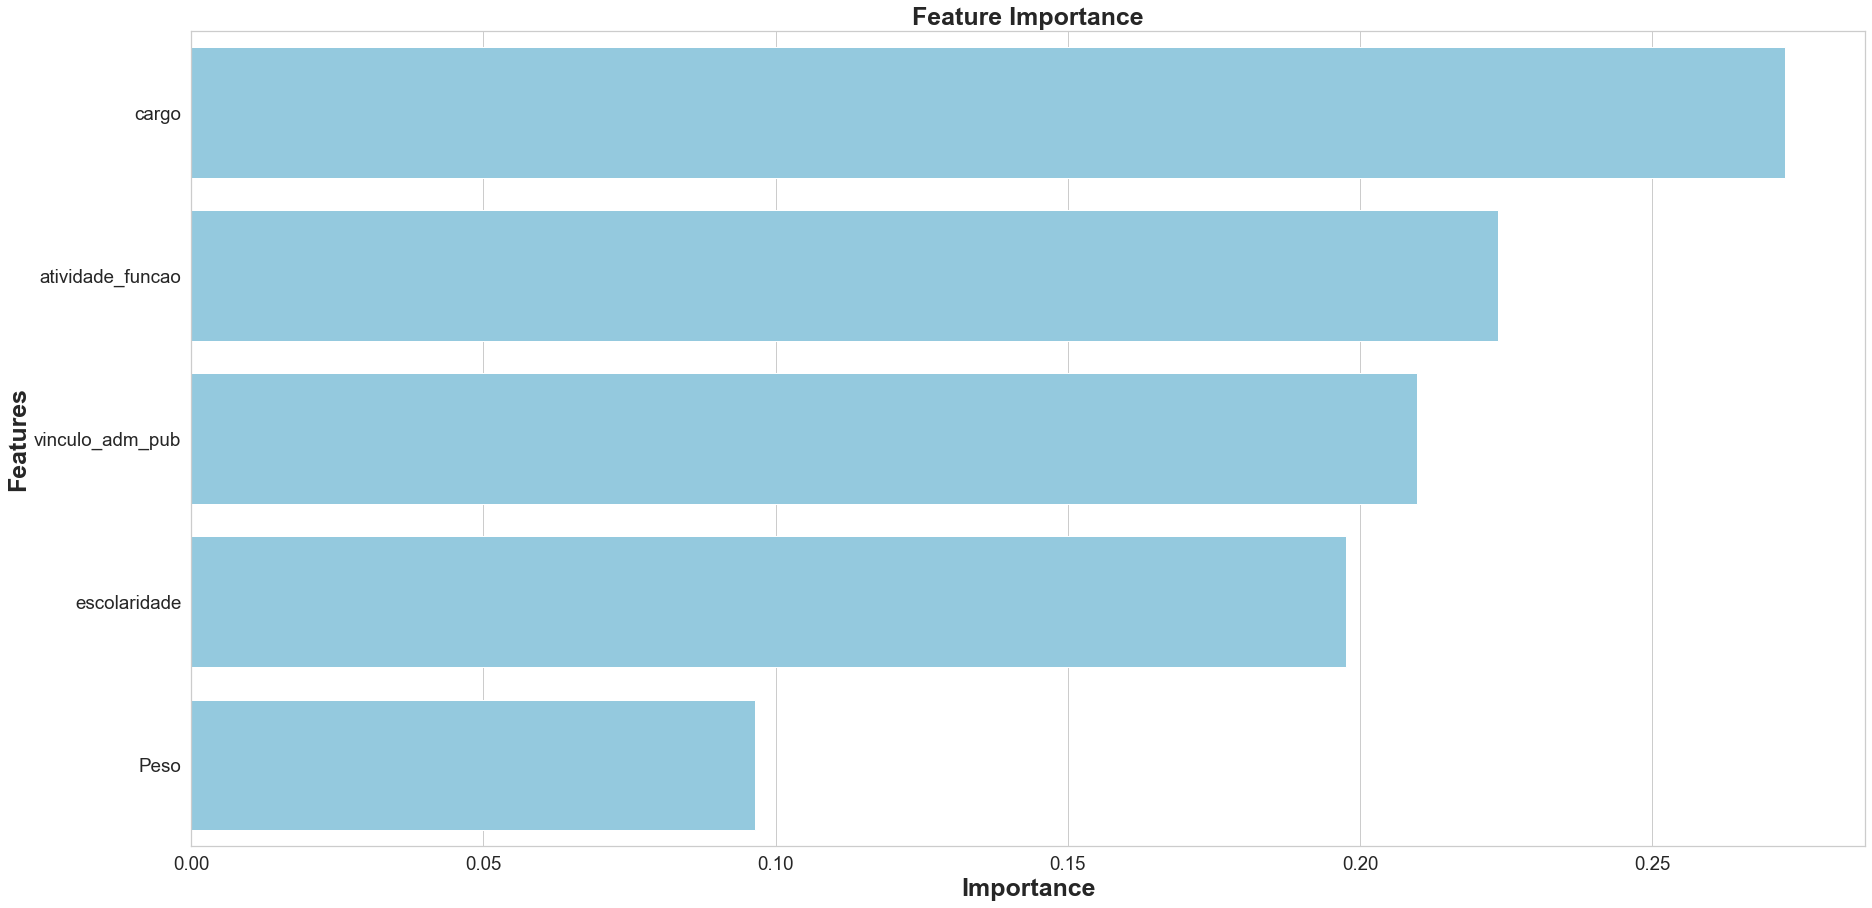

None

,Features,Gini-Importance
0,cargo,0.272729
1,atividade_funcao,0.223624
2,vinculo_adm_pub,0.209636
3,escolaridade,0.197606
4,Peso,0.096405


In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

dados = df_aluno[['escolaridade', 'vinculo_adm_pub', 'cargo','atividade_funcao','Peso']]

feats = {}
for feature, importance in zip(dados.columns, rf.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30,15)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Features', fontsize=25, weight = 'bold')
plt.title('Feature Importance', fontsize=25, weight = 'bold')
display(plt.show())
display(importances)

#### Visualizando os resultados

In [22]:
# Separando os rótulos

curso = pd.DataFrame(y_train, columns=['curso'])
curso['encoding'] = y_enc
curso.drop_duplicates(subset ="encoding", inplace = True)

matriz_resultado = pd.DataFrame(rf.predict_proba(X_test), columns=curso[curso['encoding'].isin(y_enc_teste)])

matriz_resultado

,"(Compliance Concorrencial, 83)","(SIAFI Ordens Bancárias, 420)","(Personal Management - Basis of Leadership, 353)","(Gestão do Programa de Voluntariado nas Unidades Organizacionais do ICMBio, 241)","(Gestão da Estratégia com BSC - Fundamentos, 217)","(Arquivos Permanentes: recolhimento, processamento técnico, preservação e acesso, 47)","(Execução Financeira e Prestação de Contas Referentes aos Projetos Audiovisuais, 175)","(Transmissão aérea: atualização após a Covid-19, 457)","(Aprendizagem Organizacional e Trilhas de Aprendizagem, 45)","(Demonstrativo do Resultado da Avaliação Atuarial - DRAA, 124)",...,"(Sistema Eletrônico de Informações - SEI! ADMINISTRAR, 443)","(Transferências da União: Visão Geral, 455)","(Elaboração de Plano de Dados Abertos, 154)","(Introdução ao Federalismo Fiscal no Brasil, 266)","(Inteligência Emocional, 262)","(Liberdade Religiosa e Estado Laico, 295)","(Resiliência Climática na Infraestrutura de Transportes, 407)","(Português no dia-a-dia, 370)","(Introdução à Vigilância Sanitária, 281)","(Blockchain aplicada a resolução de problemas na Administração Pública, 68)"
0,0.002243,0.003524,0.000080,0.002945,0.002054,0.001363,0.000000,0.001462,0.001349,0.001119,...,0.0,0.000085,0.001549,0.000326,0.001665,0.000876,0.002706,0.000359,0.004627,0.000092
1,0.002460,0.004303,0.000021,0.002765,0.002743,0.001172,0.000000,0.001596,0.002099,0.000491,...,0.0,0.000025,0.002844,0.000163,0.001527,0.000639,0.002533,0.000123,0.003496,0.000092
2,0.002574,0.001938,0.000303,0.001412,0.002813,0.001407,0.000000,0.003015,0.005603,0.001650,...,0.0,0.000612,0.001192,0.000062,0.002378,0.002427,0.007429,0.000196,0.002079,0.000158
3,0.001263,0.002344,0.000137,0.003857,0.001593,0.000469,0.000000,0.001897,0.002043,0.008606,...,0.0,0.000142,0.000249,0.000062,0.001921,0.001748,0.000959,0.000298,0.003990,0.000209
4,0.002641,0.004485,0.000021,0.002986,0.002289,0.001150,0.000000,0.001848,0.001499,0.000560,...,0.0,0.000025,0.002252,0.000163,0.001436,0.000707,0.002701,0.000123,0.003631,0.000092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
861,0.005282,0.001786,0.000000,0.001046,0.003763,0.001875,0.000097,0.003496,0.004750,0.000059,...,0.0,0.000000,0.000911,0.000000,0.001888,0.002997,0.004657,0.000000,0.001141,0.000000
862,0.002496,0.004690,0.000080,0.004216,0.001877,0.001252,0.000000,0.001263,0.001473,0.000995,...,0.0,0.000085,0.001314,0.000062,0.001410,0.000917,0.002609,0.000359,0.007784,0.000092
863,0.000187,0.000000,0.000364,0.000382,0.000319,0.000585,0.000000,0.002098,0.000000,0.003178,...,0.0,0.001455,0.001223,0.000727,0.001594,0.001566,0.000238,0.000000,0.000070,0.000727
864,0.003653,0.003678,0.000000,0.000956,0.003076,0.001788,0.000097,0.002238,0.004205,0.000000,...,0.0,0.000000,0.002110,0.000000,0.002567,0.000935,0.003609,0.000000,0.000988,0.000000


#### Separando os resultados por usuário

In [23]:
# Número de categorias

n = 3
for i in range(0,len(matriz_resultado)):
    globals()['df_%s' % (i)] = pd.DataFrame(list(pd.DataFrame(matriz_resultado.T[:].nlargest(n, columns=[i])[i].index.tolist())[0]), columns = ['Cursos'])

# Modelo número 4: Regressão linear

## Construindo o modelo

In [24]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(tol=1e-4,fit_intercept=True,solver='newton-cg',max_iter=50,multi_class='auto').fit(X_train, y_train)

#### Visualizando os resultados

In [25]:
# Separando os rótulos

curso = pd.DataFrame(y_train)
curso['encoding'] = y_enc
curso.drop_duplicates(subset ="encoding", inplace = True)

matriz_resultado = pd.DataFrame(clf.predict_proba(X_test), columns=curso[curso['encoding'].isin(y_enc_teste)])

matriz_resultado

,"(Compliance Concorrencial, 83)","(SIAFI Ordens Bancárias, 420)","(Personal Management - Basis of Leadership, 353)","(Gestão do Programa de Voluntariado nas Unidades Organizacionais do ICMBio, 241)","(Gestão da Estratégia com BSC - Fundamentos, 217)","(Arquivos Permanentes: recolhimento, processamento técnico, preservação e acesso, 47)","(Execução Financeira e Prestação de Contas Referentes aos Projetos Audiovisuais, 175)","(Transmissão aérea: atualização após a Covid-19, 457)","(Aprendizagem Organizacional e Trilhas de Aprendizagem, 45)","(Demonstrativo do Resultado da Avaliação Atuarial - DRAA, 124)",...,"(Sistema Eletrônico de Informações - SEI! ADMINISTRAR, 443)","(Transferências da União: Visão Geral, 455)","(Elaboração de Plano de Dados Abertos, 154)","(Introdução ao Federalismo Fiscal no Brasil, 266)","(Inteligência Emocional, 262)","(Liberdade Religiosa e Estado Laico, 295)","(Resiliência Climática na Infraestrutura de Transportes, 407)","(Português no dia-a-dia, 370)","(Introdução à Vigilância Sanitária, 281)","(Blockchain aplicada a resolução de problemas na Administração Pública, 68)"
0,0.002243,0.002999,0.000194,0.000711,0.002001,0.001821,0.000547,0.001658,0.001177,0.000109,...,0.000116,0.000264,0.002453,0.000341,0.002334,0.001499,0.004839,0.000169,0.002161,0.000203
1,0.002305,0.003333,0.000098,0.004436,0.001063,0.001832,0.000876,0.000951,0.000521,0.000250,...,0.000285,0.000223,0.001572,0.000076,0.000815,0.000927,0.001979,0.001087,0.005531,0.000268
2,0.001841,0.000288,0.001298,0.000751,0.004961,0.000770,0.000044,0.005714,0.002608,0.001483,...,0.000017,0.000597,0.000254,0.000351,0.001277,0.002143,0.004990,0.000154,0.000912,0.000254
3,0.004505,0.000780,0.000176,0.005269,0.003142,0.000162,0.000007,0.004130,0.007833,0.001048,...,0.000039,0.000455,0.000020,0.000075,0.001141,0.000319,0.001519,0.000220,0.002115,0.000375
4,0.002375,0.002816,0.000122,0.004789,0.001204,0.001774,0.000731,0.001111,0.000582,0.000339,...,0.000254,0.000252,0.001327,0.000078,0.000798,0.000999,0.002058,0.001158,0.005421,0.000288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
861,0.002188,0.001054,0.000542,0.000670,0.003482,0.001300,0.000171,0.003349,0.001972,0.000375,...,0.000047,0.000423,0.000935,0.000421,0.002059,0.001985,0.005686,0.000148,0.001424,0.000236
862,0.005762,0.010178,0.000026,0.003913,0.001337,0.000431,0.000112,0.001213,0.003844,0.000056,...,0.000280,0.000199,0.000266,0.000095,0.002669,0.000243,0.001750,0.000193,0.004883,0.000292
863,0.000407,0.000056,0.001840,0.001034,0.004289,0.005261,0.000062,0.004687,0.000545,0.025157,...,0.000223,0.001271,0.000416,0.001022,0.001846,0.012783,0.000758,0.000102,0.000208,0.001007
864,0.004674,0.012489,0.000032,0.000371,0.001876,0.000471,0.000108,0.001436,0.006325,0.000010,...,0.000127,0.000168,0.000707,0.000460,0.008454,0.000351,0.004204,0.000020,0.001658,0.000166


#### Separando os resultados por usuário

In [26]:
# Número de categorias

n = 3
for i in range(0,len(matriz_resultado)):
    globals()['df_%s' % (i)] = pd.DataFrame(list(pd.DataFrame(matriz_resultado.T[:].nlargest(n, columns=[i])[i].index.tolist())[0]), columns = ['Cursos'])

# Modelo número 5: KNeighborsRegressor

## Selecionando o valor ótimo de vizinhos

In [27]:
from sklearn.neighbors import KNeighborsClassifier

error_rate = []
for i in range(1,250):
 knn = KNeighborsClassifier(n_neighbors=i)
 knn.fit(X_train,y_train)
 pred_i = knn.predict(X_test)
 error_rate.append(np.mean(pred_i != y_test))

Minimum error:- 0.9584295612009238 at K = 1


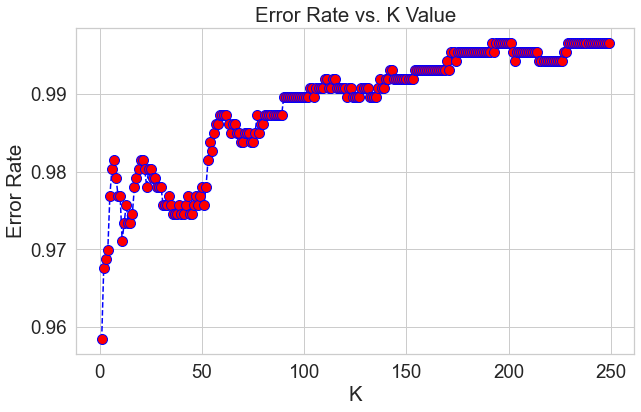

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(range(1,250),error_rate,color='blue', linestyle='dashed',marker='o',markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
req_k_value = error_rate.index(min(error_rate))+1
print("Minimum error:-",min(error_rate),"at K =",req_k_value)

Maximum accuracy:- 0.04157043879907621 at K = 0


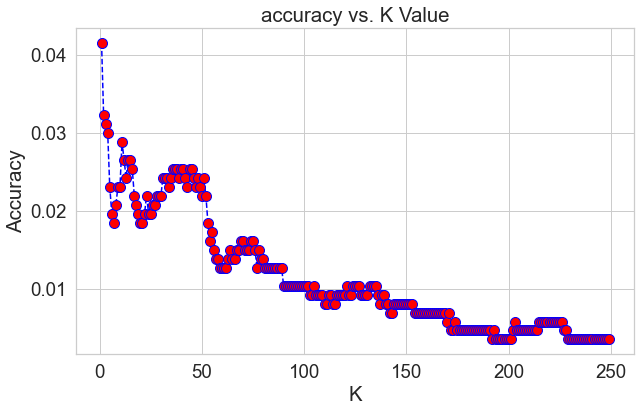

In [29]:
acc = []
# Will take some time
from sklearn import metrics
for i in range(1,250):
    neigh = KNeighborsClassifier(n_neighbors = i).fit(X_train,y_train)
    yhat = neigh.predict(X_test)
    acc.append(metrics.accuracy_score(y_test, yhat))
    
plt.figure(figsize=(10,6))
plt.plot(range(1,250),acc,color = 'blue',linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')
print("Maximum accuracy:-",max(acc),"at K =",acc.index(max(acc)))

## Construindo o modelo

In [30]:
model = KNeighborsClassifier(n_neighbors = 60)

# Train the model using the training sets
model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=60)

#### Visualizando os resultados

In [31]:
# Separando os rótulos

curso = pd.DataFrame(y_train)
curso['encoding'] = y_enc
curso.drop_duplicates(subset ="encoding", inplace = True)

matriz_resultado = pd.DataFrame(model.predict_proba(X_test), columns=curso[curso['encoding'].isin(y_enc_teste)])

matriz_resultado

,"(Compliance Concorrencial, 83)","(SIAFI Ordens Bancárias, 420)","(Personal Management - Basis of Leadership, 353)","(Gestão do Programa de Voluntariado nas Unidades Organizacionais do ICMBio, 241)","(Gestão da Estratégia com BSC - Fundamentos, 217)","(Arquivos Permanentes: recolhimento, processamento técnico, preservação e acesso, 47)","(Execução Financeira e Prestação de Contas Referentes aos Projetos Audiovisuais, 175)","(Transmissão aérea: atualização após a Covid-19, 457)","(Aprendizagem Organizacional e Trilhas de Aprendizagem, 45)","(Demonstrativo do Resultado da Avaliação Atuarial - DRAA, 124)",...,"(Sistema Eletrônico de Informações - SEI! ADMINISTRAR, 443)","(Transferências da União: Visão Geral, 455)","(Elaboração de Plano de Dados Abertos, 154)","(Introdução ao Federalismo Fiscal no Brasil, 266)","(Inteligência Emocional, 262)","(Liberdade Religiosa e Estado Laico, 295)","(Resiliência Climática na Infraestrutura de Transportes, 407)","(Português no dia-a-dia, 370)","(Introdução à Vigilância Sanitária, 281)","(Blockchain aplicada a resolução de problemas na Administração Pública, 68)"
0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.016667,0.0
1,0.000000,0.000000,0.0,0.0,0.016667,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.016667,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0
2,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.016667,0.0,0.000000,0.0
3,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0
4,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.016667,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
861,0.016667,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.016667,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0
862,0.000000,0.033333,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.016667,0.0
863,0.000000,0.000000,0.0,0.0,0.016667,0.0,0.0,0.016667,0.000000,0.016667,...,0.0,0.0,0.000000,0.0,0.0,0.016667,0.000000,0.0,0.000000,0.0
864,0.000000,0.016667,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0


#### Separando os resultados por usuário

In [32]:
# Número de categorias

n = 3
for i in range(0,len(matriz_resultado)):
    globals()['df_%s' % (i)] = pd.DataFrame(list(pd.DataFrame(matriz_resultado.T[:].nlargest(n, columns=[i])[i].index.tolist())[0]), columns = ['Cursos'])

# Modelo número 6: Modelo de XGboost

In [57]:
from sklearn.ensemble import GradientBoostingClassifier

Gradient = GradientBoostingClassifier(criterion = 'mse', max_features = 'auto',learning_rate =0.05, n_estimators = 50)
Gradient.fit(X_train,y_train)

GradientBoostingClassifier(criterion='mse', learning_rate=0.05,
                           max_features='auto', n_estimators=50)

## Grau de influencia das variáveis

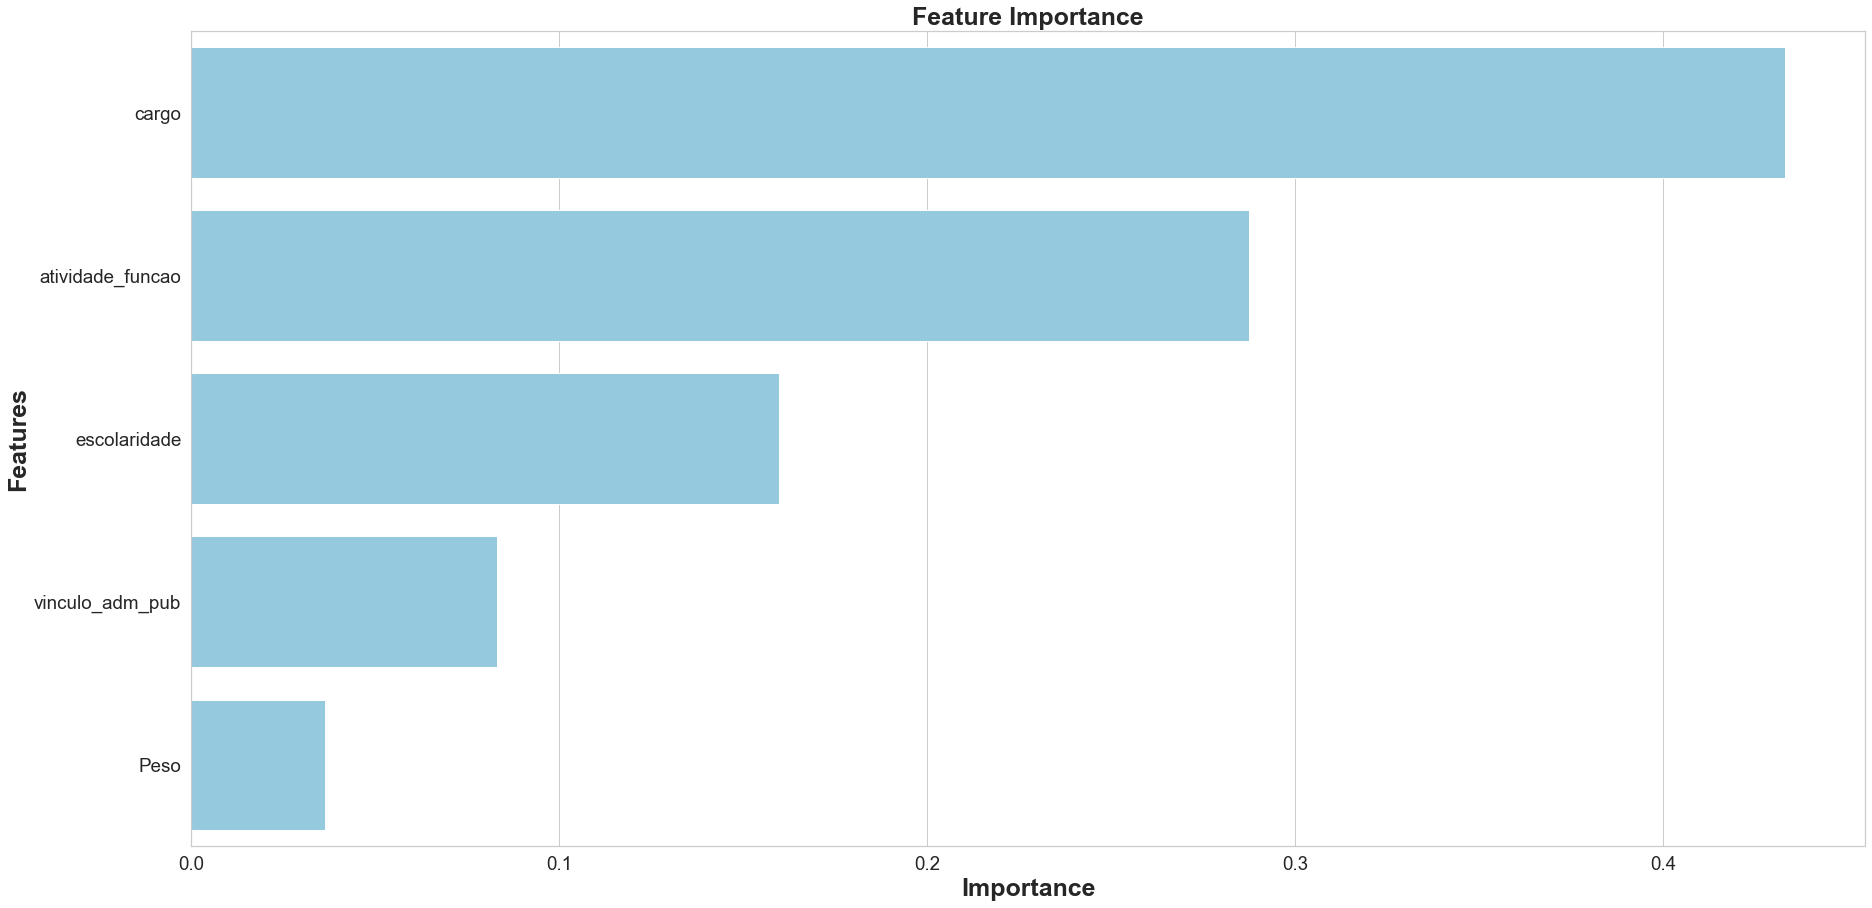

None

,Features,Gini-Importance
0,cargo,0.433276
1,atividade_funcao,0.287504
2,escolaridade,0.159678
3,vinculo_adm_pub,0.083179
4,Peso,0.036363


In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

dados = df_aluno[['escolaridade',  'vinculo_adm_pub', 'cargo','atividade_funcao','Peso']]

feats = {}
for feature, importance in zip(dados.columns, Gradient.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30,15)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Features', fontsize=25, weight = 'bold')
plt.title('Feature Importance', fontsize=25, weight = 'bold')
display(plt.show())
display(importances)

#### Visualizando os resultados

In [59]:
# Separando os rótulos

curso = pd.DataFrame(y_train)
curso['encoding'] = y_enc
curso.drop_duplicates(subset ="encoding", inplace = True)

matriz_resultado = pd.DataFrame(Gradient.predict_proba(X_test), columns=curso[curso['encoding'].isin(y_enc_teste)])

matriz_resultado

,"(Compliance Concorrencial, 83)","(SIAFI Ordens Bancárias, 420)","(Personal Management - Basis of Leadership, 353)","(Gestão do Programa de Voluntariado nas Unidades Organizacionais do ICMBio, 241)","(Gestão da Estratégia com BSC - Fundamentos, 217)","(Arquivos Permanentes: recolhimento, processamento técnico, preservação e acesso, 47)","(Execução Financeira e Prestação de Contas Referentes aos Projetos Audiovisuais, 175)","(Transmissão aérea: atualização após a Covid-19, 457)","(Aprendizagem Organizacional e Trilhas de Aprendizagem, 45)","(Demonstrativo do Resultado da Avaliação Atuarial - DRAA, 124)",...,"(Sistema Eletrônico de Informações - SEI! ADMINISTRAR, 443)","(Transferências da União: Visão Geral, 455)","(Elaboração de Plano de Dados Abertos, 154)","(Introdução ao Federalismo Fiscal no Brasil, 266)","(Inteligência Emocional, 262)","(Liberdade Religiosa e Estado Laico, 295)","(Resiliência Climática na Infraestrutura de Transportes, 407)","(Português no dia-a-dia, 370)","(Introdução à Vigilância Sanitária, 281)","(Blockchain aplicada a resolução de problemas na Administração Pública, 68)"
0,0.000365,0.001542,0.000367,0.000816,0.000698,0.000470,0.000459,0.000639,0.000367,0.000459,...,0.000348,0.000459,0.000434,0.000367,0.000391,0.000367,0.001035,0.000367,0.000004,0.000367
1,0.000223,0.000727,0.000144,0.000430,0.020775,0.000242,0.000180,0.000543,0.000144,0.000181,...,0.000155,0.000181,0.024531,0.000145,0.000154,0.000144,0.000222,0.000144,0.000220,0.000144
2,0.000384,0.000937,0.000241,0.000416,0.001662,0.000323,0.000301,0.000934,0.000330,0.000301,...,0.000217,0.000301,0.000516,0.000241,0.000452,0.000552,0.014725,0.000241,0.000241,0.000241
3,0.000111,0.000437,0.000094,0.000890,0.000470,0.000152,0.000117,0.000171,0.000128,0.000319,...,0.000085,0.000117,0.000111,0.000094,0.000176,0.000156,0.000319,0.000094,0.000180,0.000094
4,0.000492,0.001601,0.000318,0.000948,0.000605,0.000407,0.000398,0.001014,0.000318,0.000398,...,0.000497,0.000398,0.002110,0.000318,0.000339,0.000318,0.000723,0.000318,0.000485,0.000318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
861,0.020370,0.001117,0.000287,0.000496,0.000546,0.000385,0.000359,0.000527,0.000699,0.000359,...,0.000259,0.000359,0.000616,0.000287,0.000337,0.000893,0.001480,0.000287,0.000287,0.000287
862,0.000040,0.000158,0.000034,0.000768,0.000064,0.000070,0.000042,0.000099,0.000034,0.000042,...,0.000032,0.000042,0.000040,0.000034,0.000036,0.000034,0.000109,0.000034,0.000052,0.000034
863,0.000089,0.000218,0.000056,0.000071,0.001879,0.000214,0.000070,0.001561,0.000077,0.000678,...,0.000110,0.000069,0.000058,0.000055,0.000056,0.000451,0.000190,0.000056,0.000150,0.002590
864,0.004755,0.000431,0.000103,0.000228,0.000195,0.000131,0.000128,0.000172,0.000250,0.000128,...,0.000160,0.000128,0.001654,0.000103,0.000109,0.000165,0.000290,0.000103,0.000103,0.000103


#### Separando os resultados por usuário

In [60]:
# Número de categorias

n = 3
for i in range(0,len(matriz_resultado)):
    globals()['df_%s' % (i)] = pd.DataFrame(list(pd.DataFrame(matriz_resultado.T[:].nlargest(n, columns=[i])[i].index.tolist())[0]), columns = ['Cursos'])

# Criando uma base de validação

In [37]:
df_aluno[df_aluno['orgao'].isin(['ME','ENAP'])].to_csv("df_filtro_ME_ENAP.txt", index=False, encoding='utf-8-sig', sep = '|')

### Separando as variáveis

In [38]:
# Entrando com os pacotes necessários

import numpy as np
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor

# Separando as variáveis de interesse no estudo 

X_valid = df_aluno[df_aluno['orgao'].isin(['ME','ENAP'])][['escolaridade',  'vinculo_adm_pub','cargo','atividade_funcao','Peso']].values
X_valid = X_valid.astype(str)

y_valid = df_aluno[df_aluno['orgao'].isin(['ME','ENAP'])]['curso']

# Shape do dataset

print(f'Shape: {X_valid.shape}, {y_valid.shape}')

Shape: (11197, 5), (11197,)


### Aplicando o CountEncoder

In [39]:
import category_encoders
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Separando a base em duas partes
df_encoding_valid = pd.DataFrame(X_valid, columns=['escolaridade',  'vinculo_adm_pub','cargo','atividade_funcao','Peso']) 

# CountEncoder
df_encoding_cat_treino_valid = df_encoding_valid[['escolaridade',  'vinculo_adm_pub', 'cargo','atividade_funcao']]

modelo_count = category_encoders.CountEncoder()
modelo_count.fit(df_encoding_cat_treino.to_numpy())

X_enc_teste = modelo_count.transform(df_encoding_cat_treino_valid.to_numpy())

# Retornando para numpy array
df_encoding_result = pd.concat([X_enc_teste,df_encoding_valid[['Peso']]], axis=1)
df_encoding_result.rename(columns = {0:'escolaridade', 1:'vinculo_adm_pub' , 2:'cargo', 3:'atividade_funcao'}, inplace = True)
X_enc_teste = df_encoding_result.to_numpy()

# Realizando uma padronização na escala das variáveis

scaler = StandardScaler()
scaler.fit(X_enc_treino)
x_cat_teste_matriz = scaler.transform(X_enc_teste)

X_enc_valid = pd.DataFrame(x_cat_teste_matriz, columns=['escolaridade', 'vinculo_adm_pub', 'cargo','atividade_funcao','Peso']) 

print(X_enc_valid.shape)

# Codificando atributo alvo

label_enc = LabelEncoder()
label_enc.fit(y_train)
y_enc_valid = label_enc.transform(y_valid)

(11197, 5)


### Aplicando uma normalização

In [40]:
scaler = StandardScaler()
scaler.fit(X_enc)
X_enc_valid = scaler.transform(X_enc_valid)

#### RandomForest

In [54]:
# Separando os rótulos

curso = pd.DataFrame(y_train, columns=['curso'])
curso['encoding'] = y_enc
curso.drop_duplicates(subset ="encoding", inplace = True)

matriz_resultado = pd.DataFrame(rf.predict_proba(X_enc_valid), columns=curso[curso['encoding'].isin(y_enc)])

matriz_resultado

,"(Compliance Concorrencial, 83)","(SIAFI Ordens Bancárias, 420)","(Personal Management - Basis of Leadership, 353)","(Gestão do Programa de Voluntariado nas Unidades Organizacionais do ICMBio, 241)","(Gestão da Estratégia com BSC - Fundamentos, 217)","(Arquivos Permanentes: recolhimento, processamento técnico, preservação e acesso, 47)","(Execução Financeira e Prestação de Contas Referentes aos Projetos Audiovisuais, 175)","(Transmissão aérea: atualização após a Covid-19, 457)","(Aprendizagem Organizacional e Trilhas de Aprendizagem, 45)","(Demonstrativo do Resultado da Avaliação Atuarial - DRAA, 124)",...,"(Sistema Eletrônico de Informações - SEI! ADMINISTRAR, 443)","(Transferências da União: Visão Geral, 455)","(Elaboração de Plano de Dados Abertos, 154)","(Introdução ao Federalismo Fiscal no Brasil, 266)","(Inteligência Emocional, 262)","(Liberdade Religiosa e Estado Laico, 295)","(Resiliência Climática na Infraestrutura de Transportes, 407)","(Português no dia-a-dia, 370)","(Introdução à Vigilância Sanitária, 281)","(Blockchain aplicada a resolução de problemas na Administração Pública, 68)"
0,0.000137,0.000865,0.009718,0.000381,0.000446,0.000000,0.001222,0.000411,0.001064,0.001319,...,0.000078,0.008236,0.000119,0.001683,0.002076,0.000137,0.000104,0.007500,0.000860,0.001847
1,0.000000,0.000000,0.005858,0.000000,0.000000,0.000000,0.012543,0.000000,0.000000,0.000000,...,0.021576,0.011420,0.004256,0.005583,0.000112,0.000000,0.000000,0.011653,0.000000,0.018978
2,0.000000,0.000000,0.002186,0.000000,0.000000,0.000000,0.023778,0.000000,0.000000,0.000000,...,0.020352,0.007901,0.012007,0.007661,0.000112,0.000000,0.000000,0.002803,0.000000,0.012854
3,0.000000,0.000000,0.001656,0.000000,0.000000,0.000000,0.028371,0.000000,0.000000,0.000000,...,0.029209,0.004513,0.004393,0.002413,0.000112,0.000000,0.000000,0.002856,0.000000,0.011294
4,0.000196,0.000333,0.009801,0.000422,0.000097,0.000000,0.003654,0.000041,0.000250,0.000000,...,0.002866,0.013436,0.000296,0.003231,0.000104,0.000000,0.000104,0.019619,0.000875,0.011980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11192,0.002976,0.013150,0.000021,0.002451,0.002009,0.000836,0.000000,0.001455,0.005938,0.000374,...,0.000000,0.000025,0.001569,0.000163,0.001661,0.000536,0.003120,0.000123,0.004569,0.000092
11193,0.002608,0.003968,0.000080,0.004398,0.002075,0.001276,0.000000,0.001399,0.001354,0.001112,...,0.000000,0.000085,0.001559,0.000163,0.001410,0.000986,0.002936,0.000359,0.007254,0.000092
11194,0.002836,0.003726,0.000196,0.005828,0.001917,0.001377,0.000000,0.001204,0.001401,0.001415,...,0.000000,0.000201,0.001365,0.000062,0.001432,0.001087,0.002676,0.000534,0.009892,0.000209
11195,0.001617,0.005905,0.000080,0.003064,0.001039,0.000546,0.000000,0.002769,0.001770,0.000376,...,0.000000,0.000059,0.000429,0.000062,0.000912,0.000224,0.002384,0.000257,0.006938,0.000041


In [55]:
# Número de categorias

df_random_forest = pd.DataFrame(columns=['Recomendacao 1','Recomendacao 2','Recomendacao 3'])

n = 4
for i in range(0,len(matriz_resultado)):
    lista_curso = [pd.DataFrame(list(pd.DataFrame(matriz_resultado.T[:].nlargest(n, columns=[i])[i].index.tolist())[0]), columns = ['']).T[0][0],
                                        pd.DataFrame(list(pd.DataFrame(matriz_resultado.T[:].nlargest(n, columns=[i])[i].index.tolist())[0]), columns = ['']).T[1][0],
                                        pd.DataFrame(list(pd.DataFrame(matriz_resultado.T[:].nlargest(n, columns=[i])[i].index.tolist())[0]), columns = ['']).T[2][0],
                                        pd.DataFrame(list(pd.DataFrame(matriz_resultado.T[:].nlargest(n, columns=[i])[i].index.tolist())[0]), columns = ['']).T[3][0]]

    try:
        lista_curso.remove(df_aluno[df_aluno['orgao'].isin(['ME','ENAP'])].reset_index()['curso'][i])
    except:
        pass

    df_random_forest.loc[len(df_random_forest.index)] =lista_curso[0:3]

df_random_forest.to_csv("df_random_forest.txt", index=False, encoding='utf-8-sig', sep = '|')

In [56]:
df_random_forest

,Recomendacao 1,Recomendacao 2,Recomendacao 3
0,Fiscalização de Projetos e Obras de Engenharia,Sistema Eletrônico de Informações - SEI! USAR,Fundamentos da Lei Geral de Proteção de Dados
1,Seleção de Fornecedores de Tecnologia da Infor...,Análise de riscos para contratações de TIC,Learning with Python
2,Fiscalização na Gestão do Patrimônio da União,Gestão por Competências,Introdução ao G N U/Linux
3,Gestão por Competências,Contratações de Encomendas Tecnológicas,"Misturas Asfálticas - Conceituação, Materiais ..."
4,Solução Pacífica de Conflitos no âmbito da Adm...,Criação de Reservas Particulares do Patrimônio...,Noções Gerais de Direitos Autorais
...,...,...,...
11192,SIAFI Ordens Bancárias,Acesso a Recursos do Saneamento: Mecanismos OG...,Segurança do paciente e Qualidade em serviços ...
11193,Teletrabalho e Educação a Distância,SCDP - Aprovação e Pagamento,Introdução à Vigilância Sanitária
11194,Elaboração do Plano Plurianual 2020-2023,Introdução à Vigilância Sanitária,Teletrabalho e Educação a Distância
11195,Gestão de Contratos de Tecnologia da Informaçã...,Redação Oficial e Noções de SEI e suas aplicações,Promoção e Defesa dos Direitos LGBT


#### Regressão linear

In [44]:
# Separando os rótulos

curso = pd.DataFrame(y_train, columns=['curso'])
curso['encoding'] = y_enc
curso.drop_duplicates(subset ="encoding", inplace = True)

matriz_resultado = pd.DataFrame(clf.predict_proba(X_enc_valid), columns=curso[curso['encoding'].isin(y_enc)])

matriz_resultado

,"(Compliance Concorrencial, 83)","(SIAFI Ordens Bancárias, 420)","(Personal Management - Basis of Leadership, 353)","(Gestão do Programa de Voluntariado nas Unidades Organizacionais do ICMBio, 241)","(Gestão da Estratégia com BSC - Fundamentos, 217)","(Arquivos Permanentes: recolhimento, processamento técnico, preservação e acesso, 47)","(Execução Financeira e Prestação de Contas Referentes aos Projetos Audiovisuais, 175)","(Transmissão aérea: atualização após a Covid-19, 457)","(Aprendizagem Organizacional e Trilhas de Aprendizagem, 45)","(Demonstrativo do Resultado da Avaliação Atuarial - DRAA, 124)",...,"(Sistema Eletrônico de Informações - SEI! ADMINISTRAR, 443)","(Transferências da União: Visão Geral, 455)","(Elaboração de Plano de Dados Abertos, 154)","(Introdução ao Federalismo Fiscal no Brasil, 266)","(Inteligência Emocional, 262)","(Liberdade Religiosa e Estado Laico, 295)","(Resiliência Climática na Infraestrutura de Transportes, 407)","(Português no dia-a-dia, 370)","(Introdução à Vigilância Sanitária, 281)","(Blockchain aplicada a resolução de problemas na Administração Pública, 68)"
0,0.001137,0.000213,0.007502,0.000182,0.001249,0.000030,0.000167,0.001479,0.004233,0.000066,...,0.000283,0.014037,0.000116,0.006782,0.000741,0.000094,0.000862,0.000924,0.000230,0.005599
1,0.000100,0.000070,0.004180,0.000784,0.000197,0.000990,0.012059,0.000183,0.000030,0.000755,...,0.016537,0.010695,0.002917,0.003111,0.000155,0.000681,0.000064,0.011856,0.000196,0.013279
2,0.000084,0.000152,0.002680,0.000085,0.000195,0.001173,0.019554,0.000142,0.000038,0.000068,...,0.012448,0.006730,0.011104,0.011940,0.000500,0.000749,0.000128,0.001334,0.000086,0.006930
3,0.000232,0.000611,0.000348,0.000490,0.000135,0.000303,0.004617,0.000106,0.000130,0.000033,...,0.034503,0.005251,0.001387,0.003570,0.000634,0.000126,0.000050,0.001582,0.000212,0.010549
4,0.000513,0.000401,0.003810,0.000989,0.000279,0.000237,0.012285,0.000275,0.000146,0.000091,...,0.002489,0.007173,0.002328,0.001327,0.000130,0.000175,0.000411,0.029004,0.001091,0.005376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11192,0.005395,0.014424,0.000016,0.003293,0.001022,0.000450,0.000158,0.000869,0.003069,0.000029,...,0.000353,0.000153,0.000368,0.000088,0.002789,0.000203,0.001592,0.000164,0.005026,0.000249
11193,0.002426,0.002386,0.000149,0.005114,0.001344,0.001709,0.000612,0.001278,0.000642,0.000447,...,0.000226,0.000281,0.001125,0.000080,0.000776,0.001065,0.002121,0.001221,0.005283,0.000306
11194,0.002449,0.002168,0.000165,0.005291,0.001426,0.001669,0.000553,0.001379,0.000677,0.000521,...,0.000211,0.000297,0.001022,0.000081,0.000762,0.001100,0.002152,0.001254,0.005193,0.000316
11195,0.005853,0.009629,0.000027,0.003972,0.001390,0.000411,0.000100,0.001277,0.004103,0.000061,...,0.000265,0.000206,0.000239,0.000095,0.002671,0.000241,0.001751,0.000189,0.004779,0.000297


In [45]:
# Número de categorias

df_regressao_linear = pd.DataFrame(columns=['Recomendacao 1','Recomendacao 2','Recomendacao 3'])

n = 4
for i in range(0,len(matriz_resultado)):
    lista_curso = [pd.DataFrame(list(pd.DataFrame(matriz_resultado.T[:].nlargest(n, columns=[i])[i].index.tolist())[0]), columns = ['']).T[0][0],
                                        pd.DataFrame(list(pd.DataFrame(matriz_resultado.T[:].nlargest(n, columns=[i])[i].index.tolist())[0]), columns = ['']).T[1][0],
                                        pd.DataFrame(list(pd.DataFrame(matriz_resultado.T[:].nlargest(n, columns=[i])[i].index.tolist())[0]), columns = ['']).T[2][0],
                                        pd.DataFrame(list(pd.DataFrame(matriz_resultado.T[:].nlargest(n, columns=[i])[i].index.tolist())[0]), columns = ['']).T[3][0]]

    try:
        lista_curso.remove(df_aluno[df_aluno['orgao'].isin(['ME','ENAP'])].reset_index()['curso'][i])
    except:
        pass

    df_regressao_linear.loc[len(df_regressao_linear.index)] =lista_curso[0:3]

df_regressao_linear.to_csv("df_regressao_linear.txt", index=False, encoding='utf-8-sig', sep = '|')

In [46]:
df_regressao_linear

,Recomendacao 1,Recomendacao 2,Recomendacao 3
0,Noções Básicas para Coordenar Cursos On-line,Gestão e Fiscalização de Contratos Administrat...,Nova Lei de Licitações: Sanções ao fornecedor
1,Seleção de Fornecedores de Tecnologia da Infor...,Análise de riscos para contratações de TIC,Behavioral Economics in public policies develo...
2,Fiscalização na Gestão do Patrimônio da União,Enquadramento de Corpos Dágua,Execução Financeira e Prestação de Contas Refe...
3,Gestão por Competências,Orçamento público: elaboração e execução,Sistema Eletrônico de Informações - SEI! ADMIN...
4,Solução Pacífica de Conflitos no âmbito da Adm...,Planejamento Estratégico para Organizações Púb...,Português no dia-a-dia
...,...,...,...
11192,Liberdade de Organização Religiosa: Formalizaç...,Termo de Referência ou Projeto Básico para a C...,Gestão de Contratos de Tecnologia da Informaçã...
11193,Teletrabalho e Educação a Distância,SCDP - Aprovação e Pagamento,Análise de Dados em Linguagem R
11194,Teletrabalho e Educação a Distância,Elaboração do Plano Plurianual 2020-2023,SCDP - Aprovação e Pagamento
11195,Liberdade de Organização Religiosa: Formalizaç...,Gestão de Contratos de Tecnologia da Informaçã...,Termo de Referência ou Projeto Básico para a C...


#### KNN

In [47]:
# Separando os rótulos

curso = pd.DataFrame(y_train, columns=['curso'])
curso['encoding'] = y_enc
curso.drop_duplicates(subset ="encoding", inplace = True)

matriz_resultado = pd.DataFrame(model.predict_proba(X_enc_valid), columns=curso[curso['encoding'].isin(y_enc)])

matriz_resultado

,"(Compliance Concorrencial, 83)","(SIAFI Ordens Bancárias, 420)","(Personal Management - Basis of Leadership, 353)","(Gestão do Programa de Voluntariado nas Unidades Organizacionais do ICMBio, 241)","(Gestão da Estratégia com BSC - Fundamentos, 217)","(Arquivos Permanentes: recolhimento, processamento técnico, preservação e acesso, 47)","(Execução Financeira e Prestação de Contas Referentes aos Projetos Audiovisuais, 175)","(Transmissão aérea: atualização após a Covid-19, 457)","(Aprendizagem Organizacional e Trilhas de Aprendizagem, 45)","(Demonstrativo do Resultado da Avaliação Atuarial - DRAA, 124)",...,"(Sistema Eletrônico de Informações - SEI! ADMINISTRAR, 443)","(Transferências da União: Visão Geral, 455)","(Elaboração de Plano de Dados Abertos, 154)","(Introdução ao Federalismo Fiscal no Brasil, 266)","(Inteligência Emocional, 262)","(Liberdade Religiosa e Estado Laico, 295)","(Resiliência Climática na Infraestrutura de Transportes, 407)","(Português no dia-a-dia, 370)","(Introdução à Vigilância Sanitária, 281)","(Blockchain aplicada a resolução de problemas na Administração Pública, 68)"
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.016667,0.016667,0.0,...,0.000000,0.016667,0.000000,0.016667,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.050000,0.000000,0.000000,0.0,...,0.033333,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.016667,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.016667,0.016667,0.033333,0.016667,0.0,0.0,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.033333,0.000000,0.000000,0.0,...,0.016667,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.016667
4,0.000000,0.000000,0.016667,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.016667,0.000000,0.000000,0.0,0.0,0.000000,0.050000,0.000000,0.016667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11192,0.016667,0.016667,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.016667,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.016667,0.000000,0.000000,0.000000
11193,0.000000,0.016667,0.000000,0.033333,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.016667,0.000000
11194,0.000000,0.000000,0.000000,0.033333,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.033333,0.000000
11195,0.000000,0.033333,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.016667,0.000000


In [48]:
# Número de categorias

df_knn = pd.DataFrame(columns=['Recomendacao 1','Recomendacao 2','Recomendacao 3'])

n = 4
for i in range(0,len(matriz_resultado)):
    lista_curso = [pd.DataFrame(list(pd.DataFrame(matriz_resultado.T[:].nlargest(n, columns=[i])[i].index.tolist())[0]), columns = ['']).T[0][0],
                                        pd.DataFrame(list(pd.DataFrame(matriz_resultado.T[:].nlargest(n, columns=[i])[i].index.tolist())[0]), columns = ['']).T[1][0],
                                        pd.DataFrame(list(pd.DataFrame(matriz_resultado.T[:].nlargest(n, columns=[i])[i].index.tolist())[0]), columns = ['']).T[2][0],
                                        pd.DataFrame(list(pd.DataFrame(matriz_resultado.T[:].nlargest(n, columns=[i])[i].index.tolist())[0]), columns = ['']).T[3][0]]

    try:
        lista_curso.remove(df_aluno[df_aluno['orgao'].isin(['ME','ENAP'])].reset_index()['curso'][i])
    except:
        pass

    df_knn.loc[len(df_knn.index)] =lista_curso[0:3]

df_knn.to_csv("df_knn.txt", index=False, encoding='utf-8-sig', sep = '|')

In [49]:
df_knn

,Recomendacao 1,Recomendacao 2,Recomendacao 3
0,Noções Básicas para Coordenar Cursos On-line,Reconhecimento de Riscos Químicos nos Ambiente...,Gestão e Fiscalização de Contratos Administrat...
1,Execução Financeira e Prestação de Contas Refe...,Learning with Python,Análise de riscos para contratações de TIC
2,Fiscalização na Gestão do Patrimônio da União,Auditoria de Gestão Documental: prepare-se par...,Enquadramento de Corpos Dágua
3,PNLD – Programa Nacional do Livro e do Materia...,Execução Financeira e Prestação de Contas Refe...,Legislação aplicada à logística de suprimentos...
4,Criação de Reservas Particulares do Patrimônio...,Solução Pacífica de Conflitos no âmbito da Adm...,Português no dia-a-dia
...,...,...,...
11192,Liberdade de Organização Religiosa: Formalizaç...,Estruturas de Gestão Pública,e-MAG - Cartilha técnica de acessibilidade
11193,SCDP - Aprovação e Pagamento,Teletrabalho e Educação a Distância,Análise de Dados em Linguagem R
11194,Elaboração do Plano Plurianual 2020-2023,Teletrabalho e Educação a Distância,Gestão do Programa de Voluntariado nas Unidade...
11195,Termo de Referência ou Projeto Básico para a C...,Gestão de Contratos de Tecnologia da Informaçã...,SIAFI Ordens Bancárias


#### XGboost

In [61]:
# Separando os rótulos

curso = pd.DataFrame(y_train, columns=['curso'])
curso['encoding'] = y_enc
curso.drop_duplicates(subset ="encoding", inplace = True)

matriz_resultado = pd.DataFrame(Gradient.predict_proba(X_enc_valid), columns=curso[curso['encoding'].isin(y_enc)])

matriz_resultado

,"(Compliance Concorrencial, 83)","(SIAFI Ordens Bancárias, 420)","(Personal Management - Basis of Leadership, 353)","(Gestão do Programa de Voluntariado nas Unidades Organizacionais do ICMBio, 241)","(Gestão da Estratégia com BSC - Fundamentos, 217)","(Arquivos Permanentes: recolhimento, processamento técnico, preservação e acesso, 47)","(Execução Financeira e Prestação de Contas Referentes aos Projetos Audiovisuais, 175)","(Transmissão aérea: atualização após a Covid-19, 457)","(Aprendizagem Organizacional e Trilhas de Aprendizagem, 45)","(Demonstrativo do Resultado da Avaliação Atuarial - DRAA, 124)",...,"(Sistema Eletrônico de Informações - SEI! ADMINISTRAR, 443)","(Transferências da União: Visão Geral, 455)","(Elaboração de Plano de Dados Abertos, 154)","(Introdução ao Federalismo Fiscal no Brasil, 266)","(Inteligência Emocional, 262)","(Liberdade Religiosa e Estado Laico, 295)","(Resiliência Climática na Infraestrutura de Transportes, 407)","(Português no dia-a-dia, 370)","(Introdução à Vigilância Sanitária, 281)","(Blockchain aplicada a resolução de problemas na Administração Pública, 68)"
0,3.234074e-08,2.706841e-07,6.477483e-08,8.905242e-08,3.980319e-07,4.654249e-08,4.376177e-08,1.996007e-07,0.000003,8.281936e-08,...,4.902644e-08,0.000006,4.107943e-08,2.738496e-07,6.082942e-07,7.966276e-08,1.180375e-07,3.380798e-08,9.312011e-08,5.603571e-07
1,1.207196e-04,3.637557e-04,2.111046e-02,4.984750e-04,1.485865e-04,1.455305e-03,9.832956e-05,2.361462e-04,0.000078,9.769723e-05,...,2.401275e-04,0.000513,9.232865e-05,9.180118e-05,2.899302e-04,9.319968e-04,2.517702e-04,1.031851e-04,9.795223e-05,7.550267e-04
2,4.057464e-05,1.714595e-04,1.665214e-04,9.071387e-05,5.405825e-05,1.976061e-04,2.852321e-04,5.139028e-05,0.000041,5.106583e-05,...,1.848257e-02,0.000274,7.744622e-05,1.670349e-02,4.344326e-05,5.573461e-05,6.278546e-05,5.249995e-05,4.287368e-07,3.922309e-04
3,3.699841e-03,1.380575e-02,7.313539e-04,1.362955e-04,8.700589e-05,8.919361e-04,1.374965e-02,1.620696e-04,0.000282,5.719906e-05,...,5.309630e-03,0.000307,1.900615e-04,3.182122e-04,1.108199e-04,6.242267e-05,1.221496e-04,6.040327e-05,4.543051e-05,9.759781e-05
4,1.117379e-04,3.366984e-04,1.667616e-03,2.038292e-02,1.375342e-04,1.497622e-04,9.101458e-05,2.185808e-04,0.000072,9.039306e-05,...,1.020029e-04,0.001235,8.546093e-05,8.566129e-05,7.693172e-05,7.229008e-05,2.328469e-04,1.114834e-04,1.525853e-02,1.857075e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11192,7.430287e-04,4.215971e-03,9.190759e-06,2.736975e-05,1.320628e-03,1.537601e-05,1.148415e-05,3.254715e-05,0.919282,1.148444e-05,...,9.852238e-06,0.000011,1.559382e-03,9.189525e-06,2.225564e-05,9.188011e-06,1.411028e-05,9.190759e-06,1.399156e-05,9.188673e-06
11193,5.005838e-04,1.508403e-03,3.239526e-04,7.340701e-03,6.160499e-04,6.709325e-04,4.046298e-04,1.032532e-03,0.000324,4.047358e-04,...,3.071904e-04,0.000405,3.828636e-04,3.239640e-04,3.446529e-04,3.238584e-04,1.949062e-03,3.239526e-04,4.933887e-04,3.239509e-04
11194,3.563382e-04,1.073750e-03,2.306041e-04,6.500227e-02,4.385322e-04,4.776001e-04,2.880338e-04,7.350029e-04,0.000231,2.881093e-04,...,2.078991e-04,0.000288,2.725397e-04,2.306123e-04,2.453395e-04,2.305371e-04,7.425616e-04,2.306041e-04,7.464902e-02,2.869556e-04
11195,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,...,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [62]:
# Número de categorias

XGboost = pd.DataFrame(columns=['Recomendacao 1','Recomendacao 2','Recomendacao 3'])

n = 4
for i in range(0,len(matriz_resultado)):
    lista_curso = [pd.DataFrame(list(pd.DataFrame(matriz_resultado.T[:].nlargest(n, columns=[i])[i].index.tolist())[0]), columns = ['']).T[0][0],
                                        pd.DataFrame(list(pd.DataFrame(matriz_resultado.T[:].nlargest(n, columns=[i])[i].index.tolist())[0]), columns = ['']).T[1][0],
                                        pd.DataFrame(list(pd.DataFrame(matriz_resultado.T[:].nlargest(n, columns=[i])[i].index.tolist())[0]), columns = ['']).T[2][0],
                                        pd.DataFrame(list(pd.DataFrame(matriz_resultado.T[:].nlargest(n, columns=[i])[i].index.tolist())[0]), columns = ['']).T[3][0]]

    try:
        lista_curso.remove(df_aluno[df_aluno['orgao'].isin(['ME','ENAP'])].reset_index()['curso'][i])
    except:
        pass

    XGboost.loc[len(XGboost.index)] =lista_curso[0:3]

XGboost.to_csv("df_XGboost.txt", index=False, encoding='utf-8-sig', sep = '|')

In [63]:
XGboost

,Recomendacao 1,Recomendacao 2,Recomendacao 3
0,Gestão e Fiscalização de Contratos Administrat...,Sistema Eletrônico de Informações - SEI! USAR,Panorama Teórico dos Direitos Humanos no Brasil
1,Gestão Orçamentária e Financeira,Seleção de Fornecedores de Tecnologia da Infor...,Formação de Pregoeiros
2,Introdução ao G N U/Linux,Controle Exercido por Conselhos de Assistência...,Fiscalização na Gestão do Patrimônio da União
3,Gestão Documental,A construção dos livros didáticos do PNLD,PNLD – Programa Nacional do Livro e do Materia...
4,Blockchain aplicada a resolução de problemas n...,Noções Gerais de Direitos Autorais,Acesso a Recursos do Saneamento: Mecanismos PA...
...,...,...,...
11192,Aprendizagem Organizacional e Trilhas de Apren...,Desenvolvendo Times de Alta Performance,Gestão de Riscos no Setor Público
11193,Acessibilidade em espaços urbanos,Teletrabalho e Educação a Distância,Prevenção e Detecção de Cartéis em Licitações
11194,Elaboração do Plano Plurianual 2020-2023,Introdução à Vigilância Sanitária,Avaliação em Processos de Aprendizagem e Model...
11195,Gestão de Contratos de Tecnologia da Informaçã...,Compliance Concorrencial,SIAFI Ordens Bancárias
